In [2]:
using KomaMRI, MAT, Plots, WebIO

## Implementation Optimized Shaped Pulse

- Sample A: T1 = 100ms, T2 = 50ms 
- Sample B: T1 = 50ms, T2 = 25ms

### Scanner

In [3]:
sys = Scanner();

**Scanner**

- B0 =     1.5 [T] - main magnetic field
- B1 =    1.0e-5 [T] - maximum RF amplitude
- Gmax =   0.06 [T/m] - maximum gradient
- Smax =   500 [mT/m/ms] - maximum slew-rate
- ADC_Δt = 2.0e-6 [s] - ADC raster time
- seq_Δt = 1.0e-5 [s] - sequence-block raster time
- GR_Δt =  1.0e-5 [s] - gradient raster time
- RF_Δt =  1.0e-6 [s] - RF raster time
- RF_ring_down_T = 2.0e-5 [s] - RF ring down time
- RF_dead_time_T = 0.0001 [s] - RF dead time
- ADC_dead_time_T = 1.0e-5 [s] - ADC dead time

### Sequence

In [4]:
# Importing MATLAB data
file = open("oc_field.mat", "r")

## Optimized field in Hz
RF_Hz = matread("oc_field.mat")["b1"];

# Final time and time array in seconds
tf_sp = matread("oc_field.mat")["tf_s"];
t_sp  = matread("oc_field.mat")["t_s"];

Mmax  = matread("oc_field.mat")["Mmax"];
Mmin  = matread("oc_field.mat")["Mmin"];

In [ ]:
# SEQUENCE
# convert to Tesla
RF_T = RF_Hz/γ;

# 1st block -> RF block
exc = RF(RF_T', tf_sp);

# 2nd block -> ADC block
nADC = 1 ;
durADC = 1e-3 ;
#delay = 1e-3 ;
aqc = ADC(nADC, durADC);

# concatenating the two blocks
seq  = Sequence();
seq += exc;
seq += aqc;

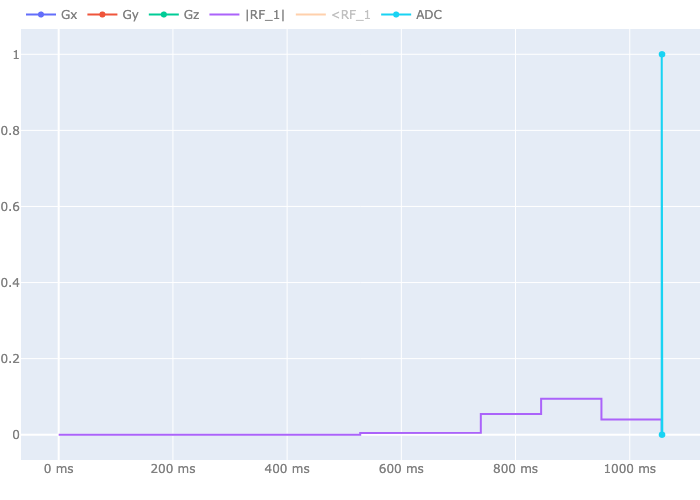

In [82]:
# plot
p1 = plot_seq(seq; slider = false, height = 300, max_rf_samples=Inf)

### Phantom

In [ ]:
obj = Phantom{Float64}(name = "spin1", x = [0.], T1 = [274e-3], T2 = [237e-3], Δw = [2π*7450]);

### Simulate

#### Signal

In [ ]:
    # SIMULATE #
    signal = simulate(obj, seq, sys; simParams=Dict{String,Any}("return_type"=>"state"));

#### Signal to magnetization

In [ ]:
Mx = real(signal.xy)[];
My = imag(signal.xy)[];
Mz = signal.z[];
sig = "max"

#### Calculating the fidelity

In [ ]:
# Fidelity
if sig == "max"
    Mxmax = Mmax[2, end]
    Mymax = Mmax[3, end]
    Mzmax = Mmax[4, end]
    fidelity_Mx = round(abs(Mx - Mxmax)*100, digits = 2)
    fidelity_My = round(abs(My - Mymax)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmax)*100, digits = 2)
else 
    Mxmin = Mmin[2, end]
    Mymin = Mmin[3, end]
    Mzmin = Mmin[4, end]
    fidelity_Mx = round(abs(Mx - Mxmin)*100, digits = 2)
    fidelity_My = round(abs(My - Mymin)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmin)*100, digits = 2)
end

In [ ]:
println("Fidelity: Mx = $fidelity_Mx%, My = $fidelity_My%, Mz = $fidelity_Mz%")

### Magnetization dynamics

In [ ]:
pieces = 50;
M_koma = zeros(Float64, 3, pieces);
t_koma = zeros(1, pieces);
for i in 1:pieces
    blocks = Int(length(RF_T)/pieces);
    rf = RF_T[1, 1:i*blocks] ;
    t_block = t_sp[1, i*blocks];

    #1st block -> RF block
    exc = RF(rf, t_block);
    
    # 2nd block -> ADC block
    nADC = 1 ;
    durADC = 1e-3 ;
    #delay = 1e-3 ;
    aqc = ADC(nADC, durADC)
    
    # concatenating the two blocks
    seq1  = Sequence();
    seq1 += exc;
    seq1 += aqc;
    #p1 = plot_seq(seq1; slider = false, height = 300, max_rf_samples=Inf)

    # PHANTOM #
    #obj1 = Phantom{Float64}(name = "spin1", x = [0.], T1 = [100e-3], T2 = [50e-3], Δw = [2π*10]);

    # SIMULATE #
    signal1 = simulate(obj, seq1, sys; simParams=Dict{String,Any}("return_type"=>"state"));

    # Magnetization
    M_koma[1, i] = real(signal1.xy)[];
    M_koma[2, i] = imag(signal1.xy)[];
    M_koma[3, i] = signal1.z[];

    # Time
    t_koma[1, i] = t_block;
end

In [ ]:
# Magnetization values
My_koma = M_koma[2,:]';
Mz_koma = M_koma[3,:]';

t_evol = LinRange(0.0, tf_sp, Int(length(RF_T)+1));

#### Plot

In [ ]:
plotly();
p_mag = plot(t_evol, Mmax[4,:], line=:solid, marker=:circle, label = "OC Grape");
plot!(t_koma', Mz_koma', seriestype=:line, marker=:circle, label = "KomaMRI");

In [ ]:
display(p_mag)